<a href="https://colab.research.google.com/github/TheHouseOfVermeulens/wernervermeulen.github.io/blob/master/Research_Trading_Algorithm_for_stocks_with_backtesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What is a Trading Algorithm?

A trading algorithm is a computer program that defines a set of rules for buying and selling assets. Most trading algorithms make decisions based on mathematical or statistical models that are derived from research conducted on historical data.

## Where do I start?

The first step to writing a trading algorithm is to find an economic or statistical relationship on which we can base our strategy. To do this, we can use Quantopian's Research environment to access and analyze historical datasets available in the platform. Research is a [Jupyter Notebook](http://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html) environment that allows us to run Python code in units called 'cells'.  

For example, the following code plots the daily closing price for Apple Inc. (AAPL), along with its 20 and 50 day moving averages:

In [0]:
# Research environment functions
from quantopian.research import prices, symbols

# Pandas library: https://pandas.pydata.org/
import pandas as pd

# Query historical pricing data for AAPL
aapl_close = prices(
    assets=symbols('AAPL'),
    start='2013-01-01',
    end='2020-01-01',
)

# Compute 20 and 50 day moving averages on
# AAPL's pricing data
aapl_sma20 = aapl_close.rolling(20).mean()
aapl_sma50 = aapl_close.rolling(50).mean()

# Combine results into a pandas DataFrame and plot
pd.DataFrame({   
    'AAPL': aapl_close,
    'SMA20': aapl_sma20,
    'SMA50': aapl_sma50
}).plot(
    title='AAPL Close Price / SMA Crossover'
);

In the next lesson we will use Research to explore Quantopian's datasets. Then, we will define our trading strategy and test whether it can effectively predict returns based on historical data. Finally, we will use our findings to develop and test a trading algorithm in the Interactive Development Environment (IDE).

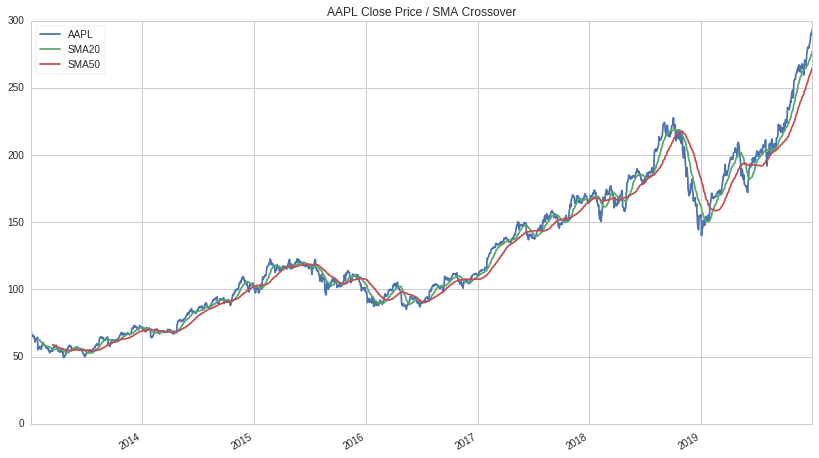

#Data Exploration
Research provides utility functions to query pricing, volume, and returns data for 8000+ US equities, from 2002 up to the most recently completed trading day. These functions take an asset (or list of assets) along with a start and end date, and return a pandas Series (or DataFrame) indexed by date.
Let's define the period of time we want to explore and use the returns function to query data for AAPL: 

In [0]:
# Research environment functions
from quantopian.research import returns, symbols

# Select a time range to inspect
period_start = '2014-01-01'
period_end = '2014-12-31'

# Query returns data for AAPL
# over the selected time range
aapl_returns = returns(
    assets=symbols('AAPL'),
    start=period_start,
    end=period_end,
)

# Display first 10 rows
aapl_returns.head(10)

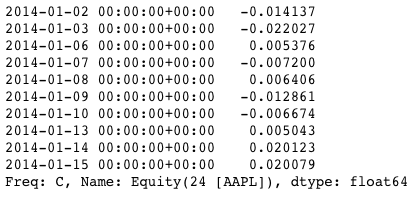

# Alternative Data
In addition to pricing and volume data, Quantopian integrates a number of other datasets that include corporate fundamentals, stock sentiment analysis, and consensus estimates, to name a few. You can find the complete list of datasets in Quantopian's Data Reference.
Our goal in this tutorial will be to build an algorithm that selects and trades assets based on sentiment data, so let's take a look at PsychSignal's StockTwits Trader Mood dataset. PsychSignal's dataset assigns bull and bear scores to stocks each day based on the aggregate sentiment from messages posted on Stocktwits, a financial communications platform.
We can start by inspecting the message volume and sentiment score (bull minus bear) columns from the stocktwits dataset. We will query the data using Quantopian's Pipeline API, which is a powerful tool you will use over and over again to access and analyze data in Research. You will learn a lot more about the Pipeline API in the next lesson and a later tutorial. For now all you need to know is that the following code uses a data pipeline to query stocktwits and returns data, and plots the results for AAPL: 

In [0]:
# Pipeline imports
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import Returns
from quantopian.pipeline.data.psychsignal import stocktwits

# Pipeline definition
def make_pipeline():

    returns = Returns(window_length=2)
    sentiment = stocktwits.bull_minus_bear.latest
    msg_volume = stocktwits.total_scanned_messages.latest

    return Pipeline(
        columns={
            'daily_returns': returns,
            'sentiment': sentiment,
            'msg_volume': msg_volume,
        },
    )

# Pipeline execution
data_output = run_pipeline(
    make_pipeline(),
    start_date=period_start,
    end_date=period_end
)

# Filter results for AAPL
aapl_output = data_output.xs(
    symbols('AAPL'),
    level=1
)

# Plot results for AAPL
aapl_output.plot(subplots=True);

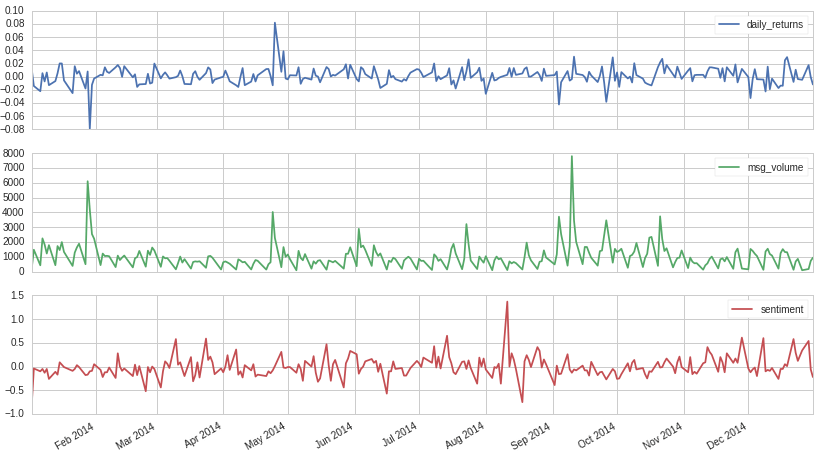

 When exploring a dataset, try to look for patterns that might serve as the basis for a trading strategy. For example, the above plot shows some matching spikes between daily returns and stocktwits message volume, and in some cases the direction of the spikes in returns match the direction of AAPL's sentiment score. This looks interesting enough that we should conduct more rigorous statistical tests to confirm our hypotheses.
In the next lesson we will cover the Pipeline API in more depth. 

# Pipeline API
The Pipeline API is a powerful tool for cross-sectional analysis of asset data. It allows us to define a set of calculations on multiple data inputs and analyze a large amount of assets at a time. Some common uses for the Pipeline API include:

    Selecting assets based on filtering rules
    Ranking assets based on a scoring function
    Calculating portfolio allocations

To begin, let's import the Pipeline class and create a function that returns an empty pipeline. Putting our pipeline definition inside a function helps us keep things organized as our pipeline grows in complexity. This is particularly helpful when transferring data pipelines between Research and the IDE. 

In [0]:
# Pipeline class
from quantopian.pipeline import Pipeline

def make_pipeline():
    # Create and return an empty Pipeline
    return Pipeline()

To add an output to our pipeline we need to include a reference to a dataset, and specify the computations we want to carry out on that data. For example, we will add a reference to the close column from the USEquityPricing dataset. Then, we can define our output to be the latest value from this column as follows: 

In [0]:
# Import Pipeline class and USEquityPricing dataset
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import USEquityPricing

def make_pipeline():
    # Get latest closing price
    close_price = USEquityPricing.close.latest

    # Return Pipeline containing latest closing price
    return Pipeline(
        columns={
            'close_price': close_price,
        }
    )

The Pipeline API also provides a number of built-in calculations, some of which are computed over trailing windows of data. For example, the following code imports Psychsignal's stocktwits dataset and defines an output as the 3 day moving average of its bull_minus_bear column: 

In [0]:
# Import Pipeline class and datasets
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import USEquityPricing
from quantopian.pipeline.data.psychsignal import stocktwits

# Import built-in moving average calculation
from quantopian.pipeline.factors import SimpleMovingAverage


def make_pipeline():
    # Get latest closing price
    close_price = USEquityPricing.close.latest

    # Calculate 3 day average of bull_minus_bear scores
    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
    )

    # Return Pipeline containing close_price
    # and sentiment_score
    return Pipeline(
        columns={
            'close_price': close_price,
            'sentiment_score': sentiment_score,
        }
    )

Universe Selection
An important part of developing a strategy is defining the set of assets that we want to consider trading in our portfolio. We usually refer to this set of assets as our trading universe. A trading universe should be as large as possible, while also excluding assets that aren't appropriate for our portfolio. For example, we might want to exclude stocks that are illiquid or difficult to trade.
Quantopian's QTradableStocksUS universe offers this characteristic. We can set QTradableStocksUS as our trading universe using the screen parameter of our pipeline constructor: 

In [0]:
# Import Pipeline class and datasets
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import USEquityPricing
from quantopian.pipeline.data.psychsignal import stocktwits

# Import built-in moving average calculation
from quantopian.pipeline.factors import SimpleMovingAverage

# Import built-in trading universe
from quantopian.pipeline.experimental import QTradableStocksUS


def make_pipeline():
    # Create a reference to our trading universe
    base_universe = QTradableStocksUS()

    # Get latest closing price
    close_price = USEquityPricing.close.latest

    # Calculate 3 day average of bull_minus_bear scores
    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
    )

    # Return Pipeline containing close_price and
    # sentiment_score that has our trading universe as screen
    return Pipeline(
        columns={
            'close_price': close_price,
            'sentiment_score': sentiment_score,
        },
        screen=base_universe,
    )

Now that our pipeline definition is complete, we can execute it over a specific period of time using run_pipeline. The output will be a pandas DataFrame indexed by date and asset, with columns corresponding to the outputs we added to our pipeline definition: 

In [0]:
# Import run_pipeline method
from quantopian.research import run_pipeline

# Execute pipeline created by make_pipeline
# between start_date and end_date
pipeline_output = run_pipeline(
    make_pipeline(),
    start_date='2013-01-01',
    end_date='2013-12-31'
)

# Display last 10 rows
pipeline_output.tail(10)

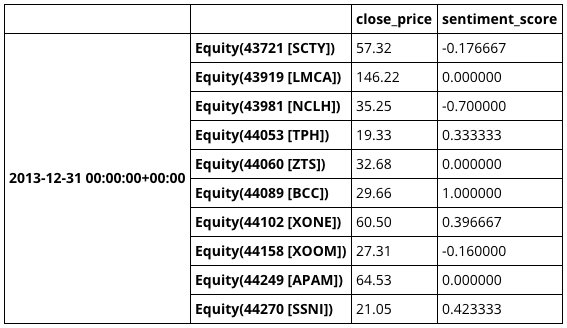

Next we will formalize the strategy our algorithm will use to select assets to trade. Then, we will use a factor analysis tool to evaluate the predictive power of our strategy over historical data. 

# Strategy Definition
Now that we have learned how to access and manipulate data in Quantopian, let's construct a data pipeline for our long-short equity strategy. In general, long-short equity strategies consist of modeling the relative value of assets with respect to each other, and placing bets on the sets of assets that we are confident will increase (long) and decrease (short) the most in value.
Long-short equity strategies profit as the spread in returns between the sets of high and low value assets increases. The quality of a long-short equity strategy relies entirely on the quality of its underling ranking model. In this tutorial we will use a simple ranking schema for our strategy:

Strategy: We will consider assets with a high 3 day average sentiment score as high value, and assets with a low 3 day average sentiment score as low value.

##Strategy Analysis
We can define the strategy above using SimpleMovingAverage and stocktwits's bull_minus_bear data, similar to the pipeline we created in the previous lesson: 

In [0]:
# Pipeline imports
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.experimental import QTradableStocksUS


# Pipeline definition
def  make_pipeline():

    base_universe = QTradableStocksUS()

    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
    )

    return Pipeline(
        columns={
            'sentiment_score': sentiment_score,
        },
        screen=base_universe
    )

For simplicity, we will only analyze the top 350 and bottom 350 stocks ranked by sentiment_score. We can create pipeline filters for these sets using the top and bottom methods of our sentiment_score output, and combine them using the | operator to get their union. Then, we will remove anything outside of our tradable universe by using the & operator to get the intersection between our filter and our universe: 

In [0]:
# Pipeline imports
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.experimental import QTradableStocksUS

# Pipeline definition
def  make_pipeline():

    base_universe = QTradableStocksUS()

    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
    )

    # Create filter for top 350 and bottom 350
    # assets based on their sentiment scores
    top_bottom_scores = (
        sentiment_score.top(350) | sentiment_score.bottom(350)
    )

    return Pipeline(
        columns={
            'sentiment_score': sentiment_score,
        },
        # Set screen as the intersection between our filter
        # and trading universe
        screen=(
            base_universe
            & top_bottom_scores
        )
    )

Next, let's execute our pipeline over the period of time we want to analyze. This will take ~1 minute. 

In [0]:
# Import run_pipeline method
from quantopian.research import run_pipeline

# Specify a time range to evaluate
period_start = '2013-01-01'
period_end = '2016-01-01'

# Execute pipeline over evaluation period
pipeline_output = run_pipeline(
    make_pipeline(),
    start_date=period_start,
    end_date=period_end
)

In addition to our pipeline's data, we will need pricing data for all assets present in this period. We can easily get a list of these assets from our pipeline output's index, and pass that list to prices to get the pricing data we need: 

In [0]:
# Import prices function
from quantopian.research import prices

# Get list of unique assets from the pipeline output
asset_list = pipeline_output.index.levels[1].unique()

# Query pricing data for all assets present during
# evaluation period
asset_prices = prices(
    asset_list,
    start=period_start,
    end=period_end
)

Now we can use Quantopian's open source factor analysis tool, Alphalens, to test the quality of our selection strategy. First, let's combine our factor and pricing data using get_clean_factor_and_forward_returns. This function classifies our factor data into quantiles and computes forward returns for each security for multiple holding periods. We will separate our factor data into 2 quantiles (the top and bottom half), and use 1, 5 and 10 day holding periods: 

In [0]:
# Import Alphalens
import alphalens as al

# Get asset forward returns and quantile classification
# based on sentiment scores
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=pipeline_output['sentiment_score'],
    prices=asset_prices,
    quantiles=2,
    periods=(1,5,10),
)

# Display first 5 rows
factor_data.head(5)

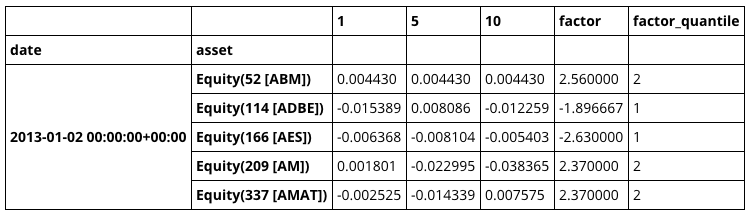

Having our data in this format allows us to use several of Alphalens's analysis and plotting tools. Let's start by looking at the mean returns by quantile over the entire period. Because our goal is to build a long-short strategy, we want to see the lower quantile (1) have negative returns and the upper quantile(2) have positive returns: 

In [0]:
# Calculate mean return by factor quantile
mean_return_by_q, std_err_by_q = al.performance.mean_return_by_quantile(factor_data)

# Plot mean returns by quantile and holding period
# over evaluation time range
al.plotting.plot_quantile_returns_bar(
    mean_return_by_q.apply(
        al.utils.rate_of_return,
        axis=0,
        args=('1D',)
    )
);

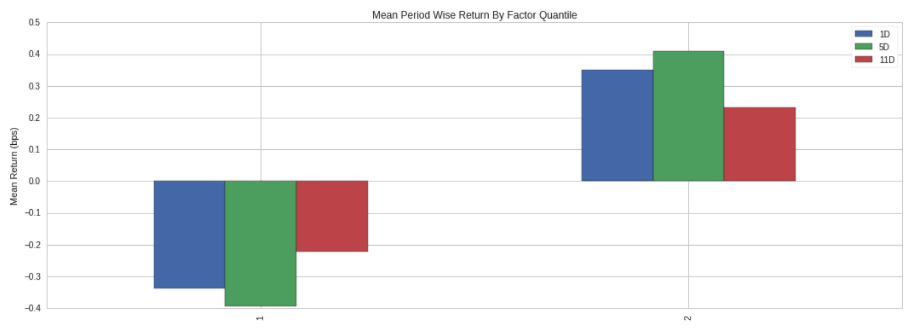

We can also plot the cumulative returns of a factor-weighted long-short portfolio with a 5 day holding period using the following code: 

In [0]:
import pandas as pd
# Calculate factor-weighted long-short portfolio returns
ls_factor_returns = al.performance.factor_returns(factor_data)

# Plot cumulative returns for 5 day holding period
al.plotting.plot_cumulative_returns(ls_factor_returns['5D'], '5D', freq=pd.tseries.offsets.BDay());

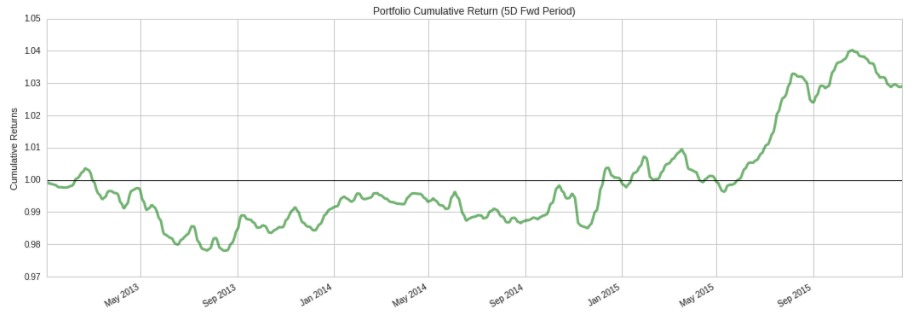

The plot above shows a large drawdown period, and this analysis does not yet take into account transaction costs or market impact. It is not a very promising strategy. At this point we really should conduct a deeper analysis using Alphalens and then iterate on our strategy idea. But for the sake of this tutorial, let's continue with our strategy as it is.
Having defined and tested a strategy, let's use it to build and test a long-short equity algorithm. 



> # Quick Recap On Above:
We created a data pipeline that selects assets to consider for our portfolio, and calculates alpha scores for those assets. 



Next we will build a trading algorithm, attach our data pipeline to it, and use alpha scores for portfolio construction. Then, we will analyze our algorithm's performance under more realistic conditions by simulating it over historical data. This type of historical simulation is commonly known as "backtesting."

# Algorithm API & Core Functions
The next step will be to build a basic structure for our trading algorithm using Quantopian's Algorithm API. The Algorithm API provides functions that facilitate order scheduling and execution, and allow us to initialize and manage parameters in our algorithms.
Let's take a look at some of the core functions we will use in our algorithm:

###initialize(context)

initialize is called exactly once when our algorithm starts running and requires context as input. Any parameter initialization and one-time startup logic should go here.

context is an augmented Python dictionary used for maintaining state throughout the simulation process, and can be referenced in different parts of our algorithm. Any variables that we want to persist between function calls should be stored in context instead of using global variables. Context variables can be accessed and initialized using dot notation (context.some_attribute).

###before_trading_start(context, data)

before_trading_start is called once per day before the market opens and requires context and data as input. context is a reference to the same dictionary from initialize, and data is an object that stores several API functions that allow us to look up current or historical pricing and volume data for any asset.

before_trading_start is also where we get our pipeline's output, and do any pre-processing of the resulting data before using it for portfolio construction. We will cover this in the next lesson.

### schedule_function(func, day_rule, time_rule)

schedule_function allows us to execute custom functions at specified dates and times. For example, we can schedule a function to rebalance our portfolio at market open on the first day of each week as follows: 

In [0]:
schedule_function(
    rebalance,
    date_rule=date_rules.week_start(),
    time_rule=time_rules.market_open()
)     

Next, we build a skeleton for our trading algorithm. For now we will have our algorithm keep track of the number of days that have passed in the simulation and log different messages depending on the date and time. Later we will integrate our data pipeline and add trading logic.

To run this example algorithm, I've created a copy / clone. Once in the IDE, run a backtest by clicking "Build Algorithm" (top left) or "Run Full Backtest" (top right). 

In [0]:
""" Cloned code from lesson 5: Skeleton for our trading algorithm! """
# Import Algorithm API
import quantopian.algorithm as algo


def initialize(context):
    # Initialize algorithm parameters
    context.day_count = 0
    context.daily_message = "Day {}."
    context.weekly_message = "Time to place some trades!"

    # Schedule rebalance function
    algo.schedule_function(
        rebalance,
        date_rule=algo.date_rules.week_start(),
        time_rule=algo.time_rules.market_open()
    )


def before_trading_start(context, data):
    # Execute any daily actions that need to happen
    # before the start of a trading session
    context.day_count += 1
    log.info(context.daily_message, context.day_count)


def rebalance(context, data):
    # Execute rebalance logic
    log.info(context.weekly_message)

# Data Processing in Algorithms
The next step is to integrate the data pipeline we built in Research into our algorithm. One important distinction from Research is that during a backtest our pipeline will be executed each day as the simulation progresses, so we won't need to include start_date and end_date arguments.

In order to use our data pipeline in an algorithm, the first step is to add a reference to it in the algorithm's initialize function. This is done using the attach_pipeline method, which requires two inputs: a reference to our Pipeline object (which we construct using make_pipeline), and a String name to identify it. 

In [0]:
# Import Algorithm API
import quantopian.algorithm as algo


def initialize(context):
    # Attach pipeline to algorithm
    algo.attach_pipeline(
        make_pipeline(),
        'data_pipe'
    )

    # Schedule rebalance function
    algo.schedule_function(
        rebalance,
        date_rule=algo.date_rules.week_start(),
        time_rule=algo.time_rules.market_open()
    )


def before_trading_start(context, data):
    # Get pipeline output and
    # store it in context
    context.pipeline_data = algo.pipeline_output(
        'data_pipe'
    )


def rebalance(context, data):
    # Display first 10 rows
    # of pipeline output
    log.info(context.pipeline_data.head(10))

As mentioned above, our pipeline will process data streams and generate an output before the market opens each day. We can get our pipeline's output in before_trading_start using the pipeline_output function, which takes the pipeline name we specified in initialize, and returns the pandas DataFrame generated by our pipeline. For now we can use our rebalance function to log the top 10 rows from our pipeline's output. 

Now, by adding the make_pipeline function we built in Research to our algorithm. Instead of limiting the number of assets like we did for our analysis, our algorithm should consider all assets in the trading universe for which it has a sentiment score. For this we can use the notnull method of our sentiment_score output to create a filter, and get its intersection with the tradable universe using the & operator: 

In [0]:
# Import Algorithm API
import quantopian.algorithm as algo

# Pipeline imports
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.filters import QTradableStocksUS


def initialize(context):
    # Attach pipeline to algorithm
    algo.attach_pipeline(
        make_pipeline(),
        'data_pipe'
    )

    # Schedule rebalance function
    algo.schedule_function(
        rebalance,
        date_rule=algo.date_rules.week_start(),
        time_rule=algo.time_rules.market_open()
    )


def before_trading_start(context, data):
    # Get pipeline output and
    # store it in context
    context.pipeline_data = algo.pipeline_output('data_pipe')


def rebalance(context, data):
    # Display first 10 rows
    # of pipeline output
    log.info(context.pipeline_data.head(10))


# Pipeline definition
def make_pipeline():

    base_universe = QTradableStocksUS()

    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
    )

    return Pipeline(
        columns={
            'sentiment_score': sentiment_score,
        },
        screen=(
            base_universe
            & sentiment_score.notnull()
        )
    )


Our algorithm now selects a tradable universe of assets each day, and produces alpha scores we can use to determine asset allocation within our portfolio. Next we will learn how to construct an optimal portfolio based on the alpha scores generated by our data pipeline. 

# Portfolio Management
Previously we incorporated a data pipeline into our trading algorithm. Now its time to define how our algorithm will use alpha scores generated by our pipeline to rebalance its portfolio. 

Our goal is to find a target portfolio that maximizes returns based on alpha scores, while maintaining a specific structure defined by a set of rules or constraints. This is usually referred to as a portfolio optimization problem.

Quantopian's Optimize API makes it easy for us to turn the output of our pipeline into an objective and a set of constraints. We can then use order_optimal_portfolio to transition our current portfolio to a target portfolio that satisfies our specifications.

The first step is to define an objective. 

We will use MaximizeAlpha, which will attempt to allocate capital to assets proportional to their alpha scores. 

In [0]:
# Import Optimize API module
import quantopian.optimize as opt


def rebalance(context, data):
  # Retrieve alpha from pipeline output
  alpha = context.pipeline_data.sentiment_score

  if not alpha.empty:
      # Create MaximizeAlpha objective
      objective = opt.MaximizeAlpha(alpha)

Next, specify the list of constraints that we want our target portfolio to satisfy. Starting by defining some threshold values in initialize and store them in our context variable: 

In [0]:
# Constraint parameters
context.max_leverage = 1.0
context.max_pos_size = 0.015
context.max_turnover = 0.95

Now, we can specify our constraints in rebalance using the thresholds we defined above:

In [0]:
# Import Optimize API module
import quantopian.optimize as opt


def rebalance(context, data):
  # Retrieve alpha from pipeline output
  alpha = context.pipeline_data.sentiment_score

  if not alpha.empty:
      # Create MaximizeAlpha objective
      objective = opt.MaximizeAlpha(alpha)

      # Create position size constraint
      constrain_pos_size = opt.PositionConcentration.with_equal_bounds(
          -context.max_pos_size,
          context.max_pos_size
      )

      # Constrain target portfolio's leverage
      max_leverage = opt.MaxGrossExposure(context.max_leverage)

      # Ensure long and short books
      # are roughly the same size
      dollar_neutral = opt.DollarNeutral()

      # Constrain portfolio turnover
      max_turnover = opt.MaxTurnover(context.max_turnover)

Finally, we can pass our objective and list of constraints to order_optimal_portfolio to calculate a target portfolio, and issue the orders necessary to transition our current portfolio to an optimal state: 

In [0]:
# Import Algorithm API
import quantopian.algorithm as algo

# Import Optimize API
import quantopian.optimize as opt


def rebalance(context, data):
  # Retrieve alpha from pipeline output
  alpha = context.pipeline_data.sentiment_score

  if not alpha.empty:
      # Create MaximizeAlpha objective
      objective = opt.MaximizeAlpha(alpha)

      # Create position size constraint
      constrain_pos_size = opt.PositionConcentration.with_equal_bounds(
          -context.max_pos_size,
          context.max_pos_size
      )

      # Constrain target portfolio's leverage
      max_leverage = opt.MaxGrossExposure(context.max_leverage)

      # Ensure long and short books
      # are roughly the same size
      dollar_neutral = opt.DollarNeutral()

      # Constrain portfolio turnover
      max_turnover = opt.MaxTurnover(context.max_turnover)

      # Rebalance portfolio using objective
      # and list of constraints
      algo.order_optimal_portfolio(
          objective=objective,
          constraints=[
              constrain_pos_size,
              max_leverage,
              dollar_neutral,
              max_turnover,
          ]
      )

# Risk Management
In addition to setting constraints on our target portfolio's structure, we will want to limit its exposure to common risk factors that could have an impact on its performance. For example, because of the transient nature of stocktwits' sentiment data and our intent to capitalize on sentiment score spikes, our algorithm could be exposed to short term reversal risk.

Our Risk Model manage our portfolio's exposure to common risk factors. The Risk Model calculates asset exposure to 16 different risk factors: 11 sector factors and 5 style factors (including short term reversal). We can easily access this data in our algorithm using the risk_loading_pipeline function, which returns a data pipeline that produces a column of output for each factor in the Risk Model.

Similar to our data pipeline, we will need to attach the risk data pipeline to our algorithm, and provide a name to identify it. Then we can get its output in before_trading_start and store it in context: 

In [0]:
# Import Algorithm API
import quantopian.algorithm as algo

# Import Risk API method
from quantopian.pipeline.experimental import risk_loading_pipeline

def initialize(context):
    # Constraint parameters
    context.max_leverage = 1.0
    context.max_pos_size = 0.015
    context.max_turnover = 0.95

    # Attach data pipelines
    algo.attach_pipeline(
        make_pipeline(),
        'data_pipe'
    )
    algo.attach_pipeline(
        risk_loading_pipeline(),
        'risk_pipe'
    )

    # Schedule rebalance function
    algo.schedule_function(
        rebalance,
        algo.date_rules.week_start(),
        algo.time_rules.market_open(),
    )


def before_trading_start(context, data):
    # Get pipeline outputs and
    # store them in context
    context.pipeline_data = algo.pipeline_output(
      'data_pipe'
    )

    context.risk_factor_betas = algo.pipeline_output(
      'risk_pipe'
    )

The next step is to add a RiskModelExposure constraint to our portfolio optimization logic. This constraint takes the data generated by the Risk Model and sets a limit on the overall exposure of our target portfolio to each of the factors included in the model.

In [0]:
# Constrain target portfolio's risk exposure
# By default, max sector exposure is set at
# 0.2, and max style exposure is set at 0.4
factor_risk_constraints = opt.experimental.RiskModelExposure(
    context.risk_factor_betas,
    version=opt.Newest
)

Finally, the following algorithm encompasses our strategy and portfolio construction logic, and is ready to be backtested. 

In [0]:
# Rebalance portfolio using objective
        # and list of constraints
        algo.order_optimal_portfolio(
            objective=objective,
            constraints=[
                constrain_pos_size,
                max_leverage,
                dollar_neutral,
                max_turnover,
                factor_risk_constraints,
            ]
        )

## Full Portfolio construction code:

In [0]:
# Import Algorithm API
import quantopian.algorithm as algo

# Import Optimize API
import quantopian.optimize as opt

# Pipeline imports
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.factors import SimpleMovingAverage

# Import built-in universe and Risk API method
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.experimental import risk_loading_pipeline


def initialize(context):
    # Constraint parameters
    context.max_leverage = 1.0
    context.max_pos_size = 0.015
    context.max_turnover = 0.95

    # Attach data pipelines
    algo.attach_pipeline(
        make_pipeline(),
        'data_pipe'
    )
    algo.attach_pipeline(
        risk_loading_pipeline(),
        'risk_pipe'
    )

    # Schedule rebalance function
    algo.schedule_function(
        rebalance,
        algo.date_rules.week_start(),
        algo.time_rules.market_open(),
    )


def before_trading_start(context, data):
    # Get pipeline outputs and
    # store them in context
    context.pipeline_data = algo.pipeline_output('data_pipe')

    context.risk_factor_betas = algo.pipeline_output('risk_pipe')


# Pipeline definition
def make_pipeline():

    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
        mask=QTradableStocksUS()
    )

    return Pipeline(
        columns={
            'sentiment_score': sentiment_score,
        },
        screen=sentiment_score.notnull()
    )


def rebalance(context, data):
    # Retrieve alpha from pipeline output
    alpha = context.pipeline_data.sentiment_score

    if not alpha.empty:
        # Create MaximizeAlpha objective
        objective = opt.MaximizeAlpha(alpha)

        # Create position size constraint
        constrain_pos_size = opt.PositionConcentration.with_equal_bounds(
            -context.max_pos_size,
            context.max_pos_size
        )

        # Constrain target portfolio's leverage
        max_leverage = opt.MaxGrossExposure(context.max_leverage)

        # Ensure long and short books
        # are roughly the same size
        dollar_neutral = opt.DollarNeutral()

        # Constrain portfolio turnover
        max_turnover = opt.MaxTurnover(context.max_turnover)

        # Constrain target portfolio's risk exposure
        # By default, max sector exposure is set at
        # 0.2, and max style exposure is set at 0.4
        factor_risk_constraints = opt.experimental.RiskModelExposure(
            context.risk_factor_betas,
            version=opt.Newest
        )

        # Rebalance portfolio using objective
        # and list of constraints
        algo.order_optimal_portfolio(
            objective=objective,
            constraints=[
                constrain_pos_size,
                max_leverage,
                dollar_neutral,
                max_turnover,
                factor_risk_constraints,
            ]
        )


# Backtest Analysis
Executing the alpha-numeric string in your notebook will load data generated by your backtest into the research notebook, and use it to create a Pyfolio tear sheet. Pyfolio is Quantopian's open source tool for portfolio and risk analysis. It provides a number of visualization tools that are designed to help you better understand your algorithm's behavior and risk exposures over time.

For example, the plot below shows our portfolio's rolling exposure to the market over time. One of the reasons we wanted to construct a long-short equity trading algorithm was to maintain a low correlation to the market, so we want this plot to be consistently around 0 over the entire backtesting period. 

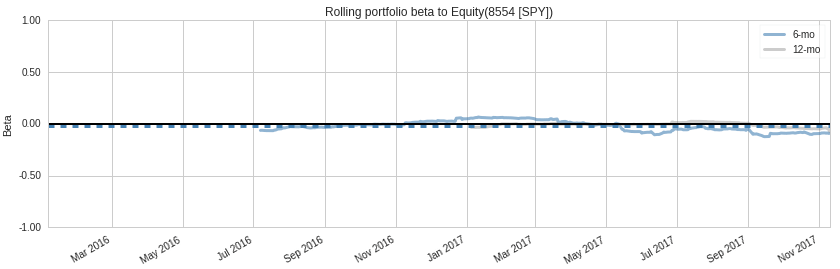

Another interesting part of the tear sheet is the Performance Attribution section. The plot below uses Quantopian's Risk Model to illustrate how much of the returns can be attributed to your strategy, and how much of it comes from common risk factors. 

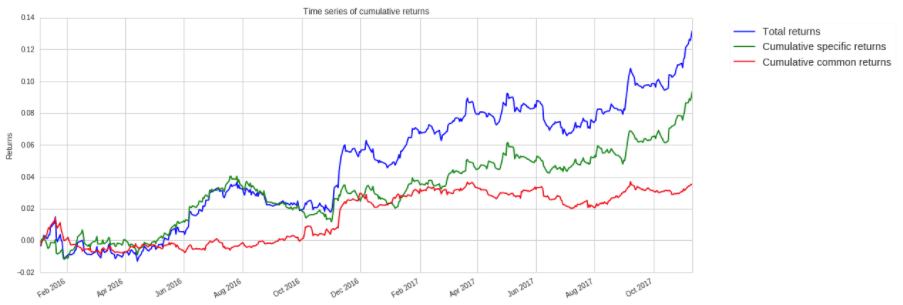

We can see above that most of our portfolio's total returns come from specific returns. This suggests the algorithm's performance isn't coming from exposure to common risk factors, which is a good thing. 

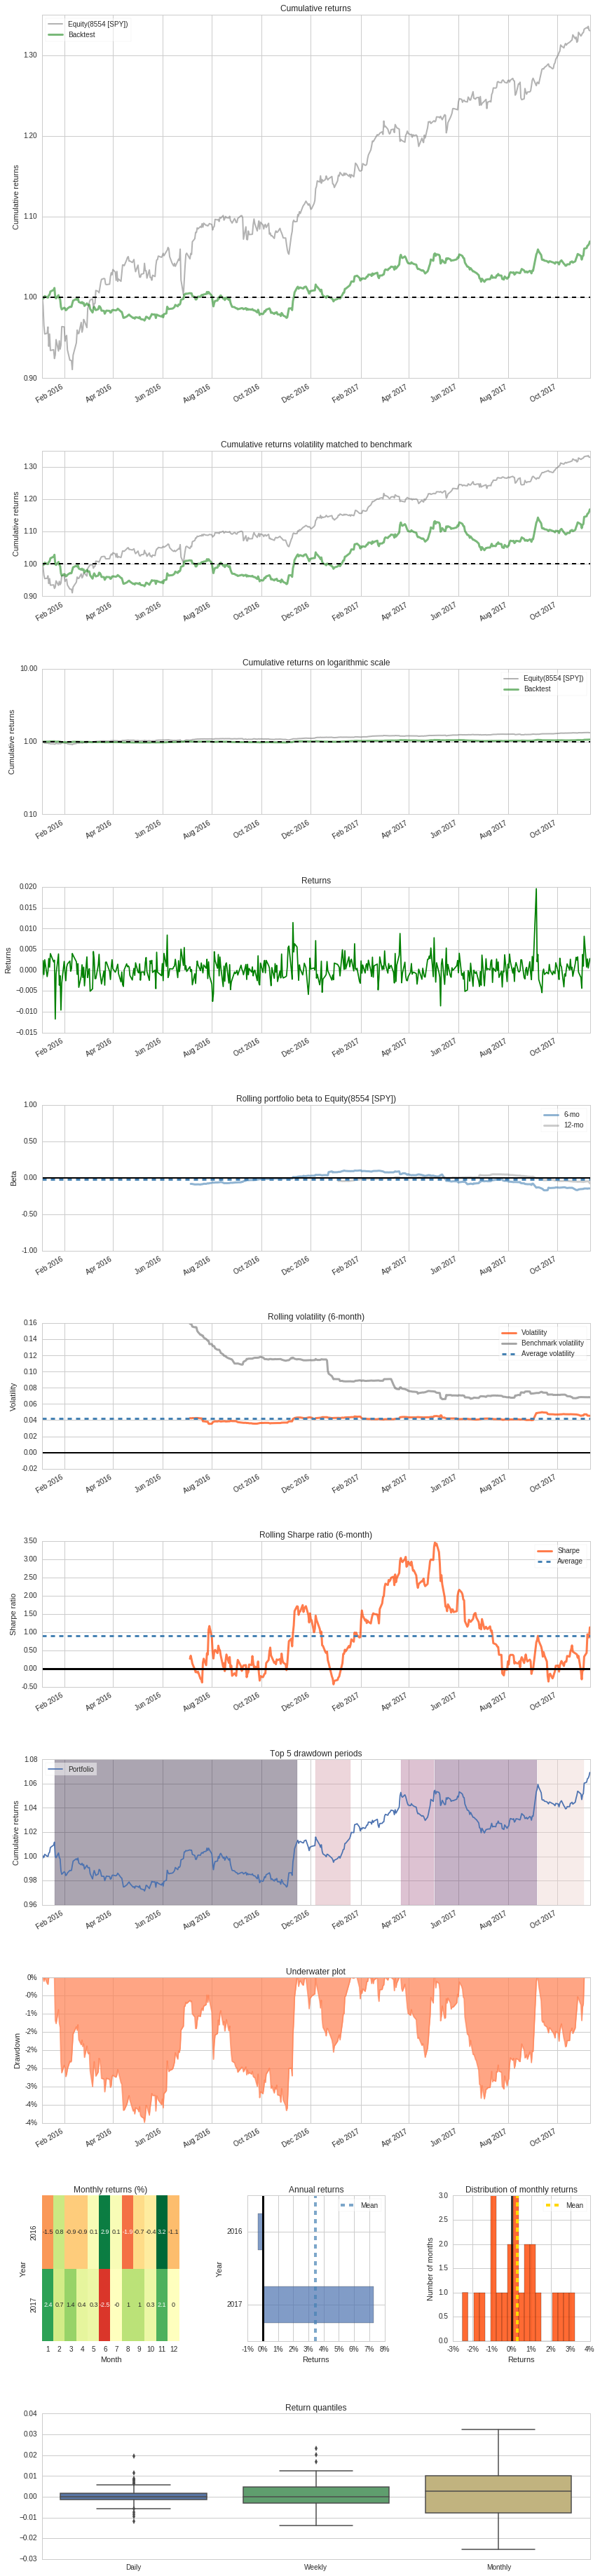

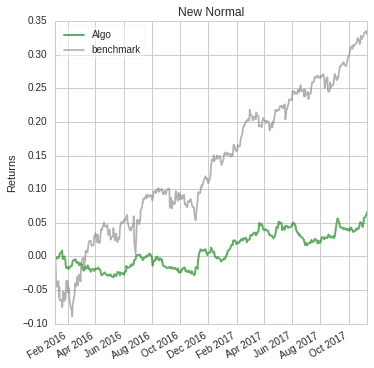

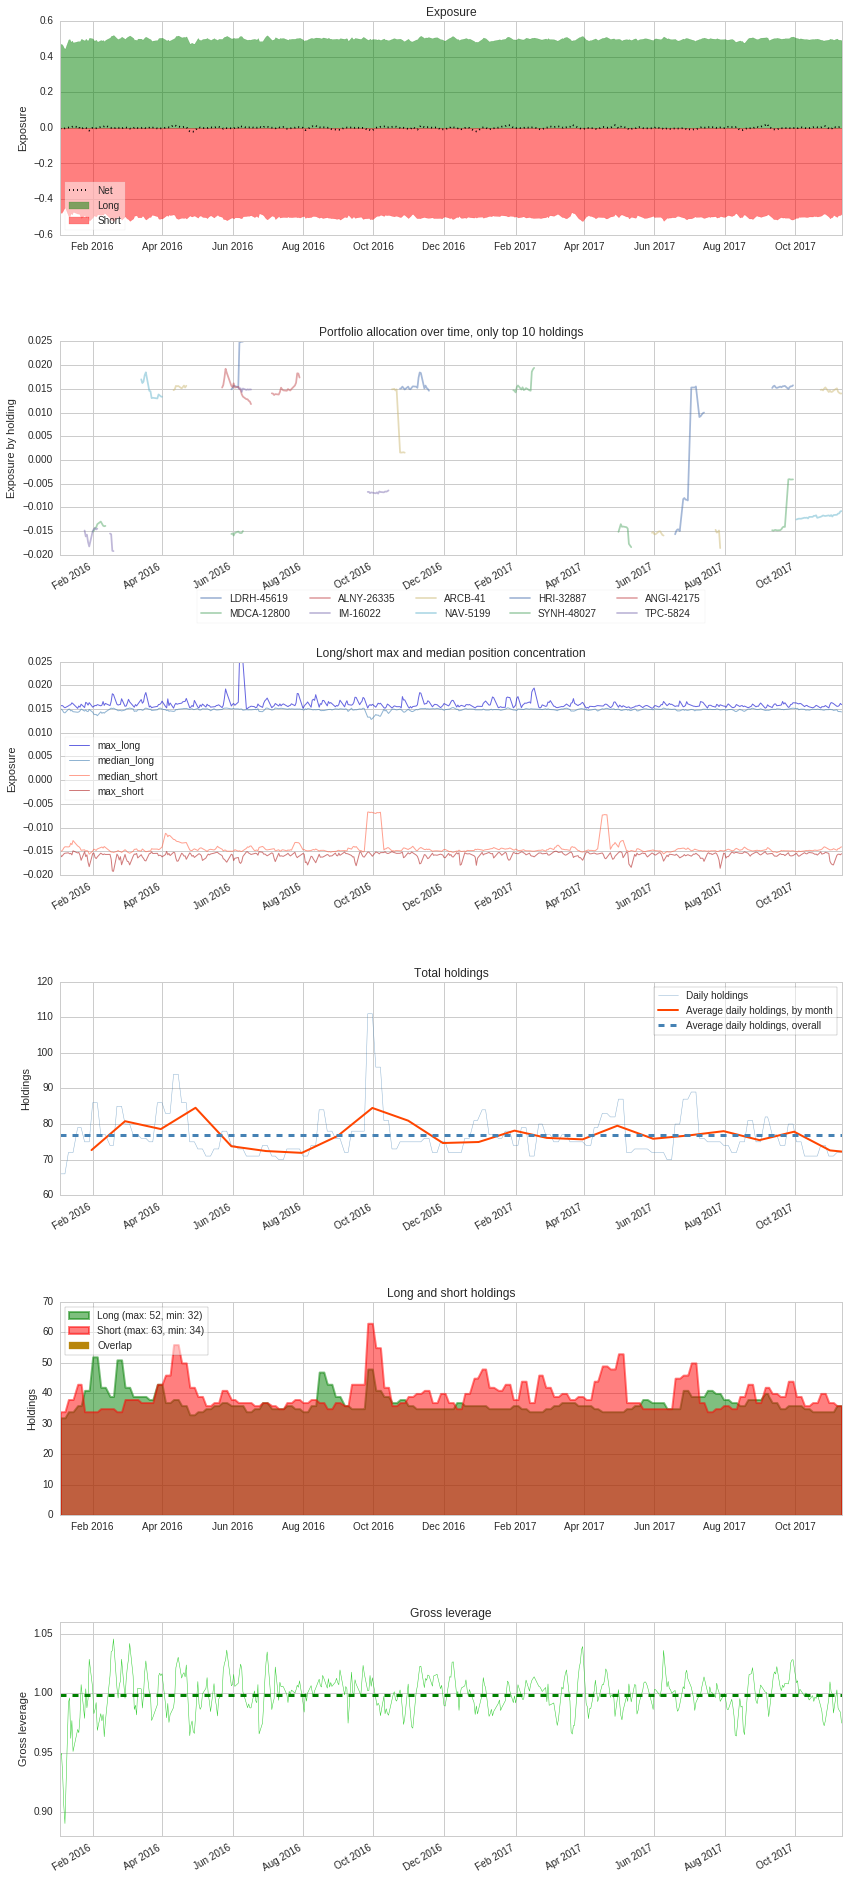

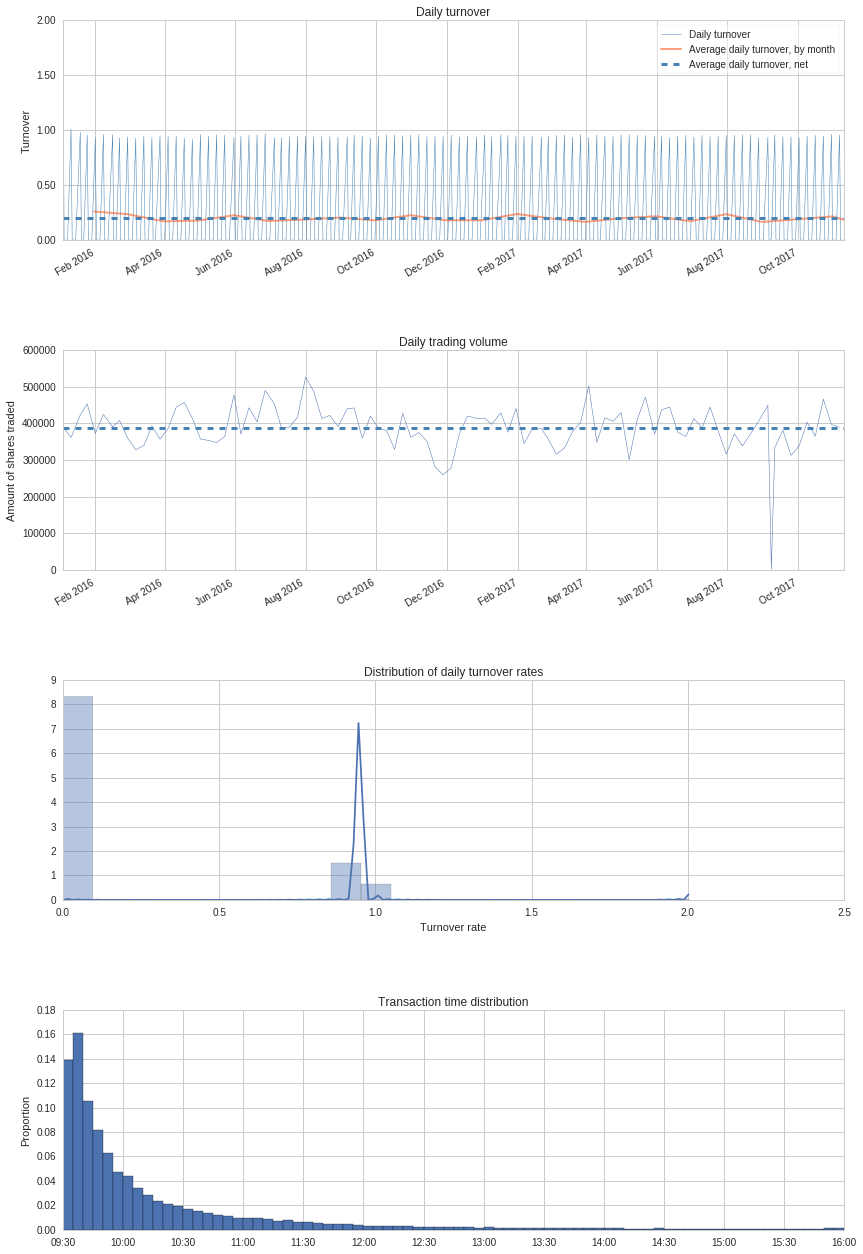

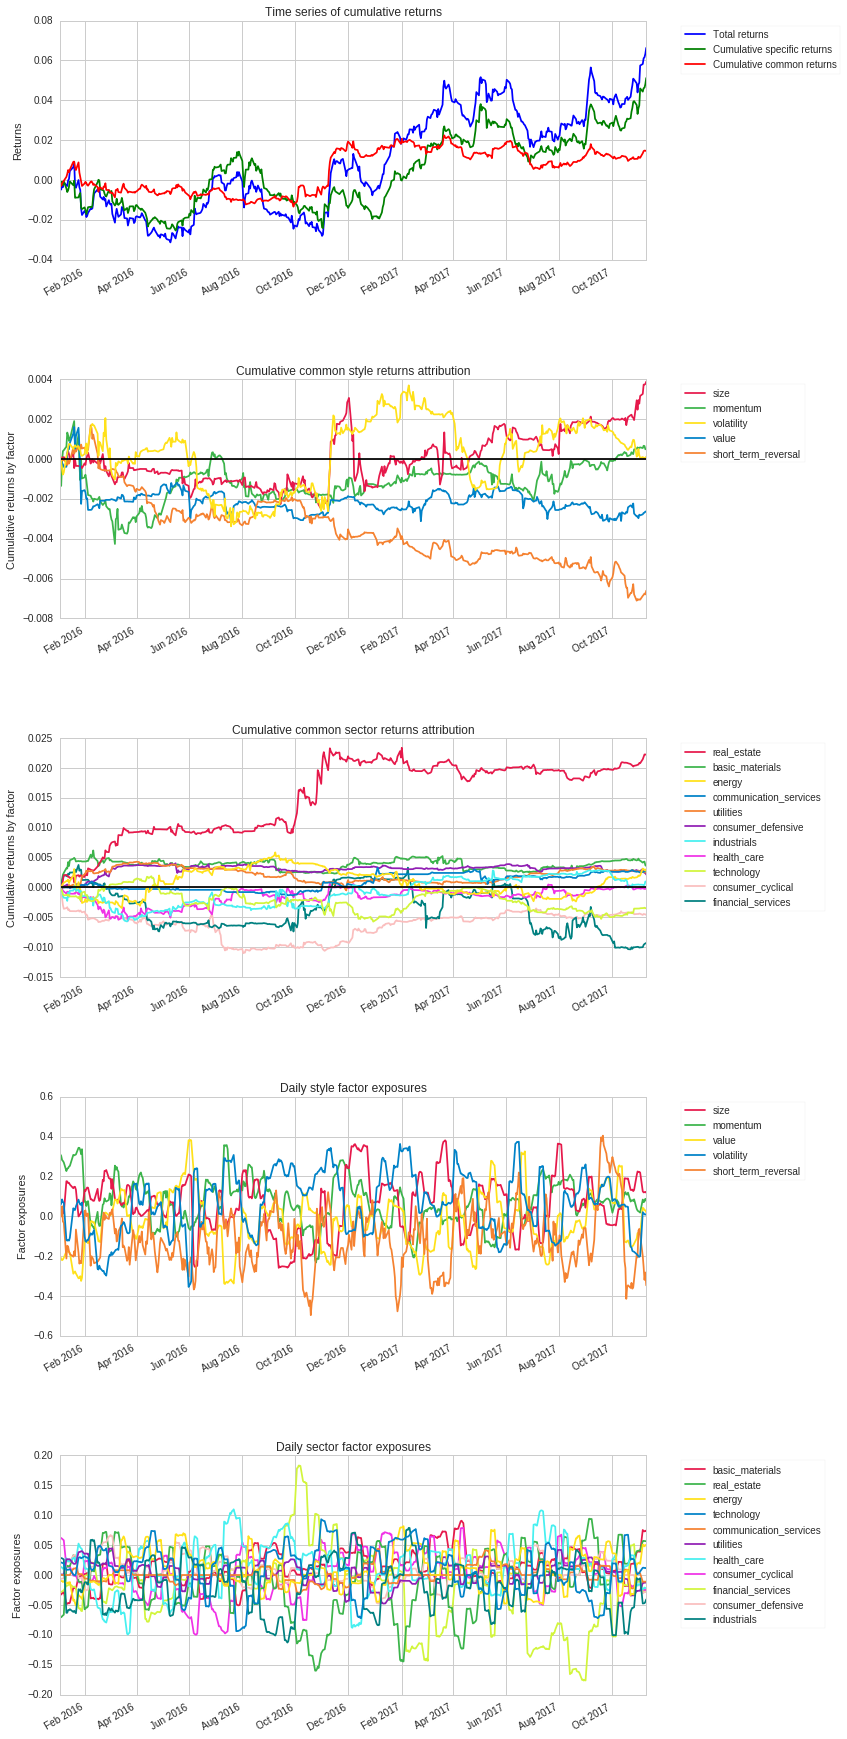